In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt

In [23]:
from oebinarytools.paths import TEST_DATA_DIR
from oebinarytools.binary import retrive_experiments, create_recordings_dict, ADC_CHANNELS
from oebinarytools.utils import norm

### load data

In [4]:
dat_files, info_files, sync_files = retrive_experiments(experiment_paths= [TEST_DATA_DIR])

In [5]:
recordings = create_recordings_dict(dat_files, info_files, sync_files)

### show example data

In [6]:
recording = recordings[0]
recording.keys()

dict_keys(['dat_file', 'info_file', 'sync_file', 'info', 'sync_message', 'FPGA_events', 'neural_data_channels', 'AUX_data_channels', 'ADC_data_channels', 'network_events', 'audio_events'])

In [7]:
# network events
recording['network_events'][:3]

,channels,metadata,text,timestamps
0,1,78987679348,trial 2020-10-16 13:23:09.197047,346841
1,1,78987685825,stim /home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_...,346841
2,1,78990340332,response right,426271


In [8]:
# audio events
recording['audio_events'][:3]

,timestamp_begin,timestamp_end,stim,metadata,channels,timestamp_stim,channel
0,356609.0,386459.0,stim /home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_...,78987685825,None,346841,1.0
1,833991.0,863841.0,stim /home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_...,79003598721,None,824321,1.0
2,1043307.0,1073157.0,stim /home/bird/opdat/cdp_stimuli/AE/NC/NC_AE_...,79010576023,None,1033985,1.0


In [9]:
# TTL events
recording['FPGA_events'][:3]

,channels,channel_states,timestamps,full_words,channel_ID
0,2,2,346971,2,Center Peck
1,5,5,347408,18,TXD
2,2,-2,348601,16,Center Peck


### plot example recording

In [52]:
time_range = [0, 40]

In [53]:
import spikeinterface.extractors as se
import numpy as np

In [54]:
# load data
dat_file = recording['dat_file']
sample_rate = recording['info']['continuous'][0]['sample_rate']
num_channels = recording['info']['continuous'][0]['num_channels']
recording_si = se.BinDatRecordingExtractor(
    dat_file, sampling_frequency=sample_rate, numchan=num_channels, dtype="int16"
)
recording_timestamps = np.load(dat_file.parent / 'timestamps.npy')

In [55]:
# get relative time
sample_start = int(time_range[0] * sample_rate)
sample_end = int(time_range[1] * sample_rate)

In [56]:
sample_ts = recording_timestamps[sample_start:sample_end]
ts_start = sample_ts[0]
ts_end = sample_ts[-1]

In [190]:
# grab audio data channels
audio_channel_number = recording['ADC_data_channels'][ADC_CHANNELS['audio']]
audio_chan = recording_si.get_traces()[audio_channel_number, sample_start:sample_end]

sine_channel_number = recording['ADC_data_channels'][ADC_CHANNELS['sine']]
sine_chan = recording_si.get_traces()[sine_channel_number, sample_start:sample_end]

In [180]:
# grad neural data channels
neural_data_traces = recording_si.get_traces()[recording['neural_data_channels'], sample_start:sample_end]

In [173]:
import seaborn as sns

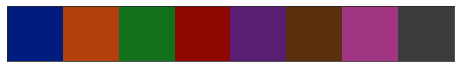

In [199]:
dio_pal = sns.color_palette('dark', 8)
sns.palplot(dio_pal)

(336896.0, 1536895.0, -1.6, 33.6)

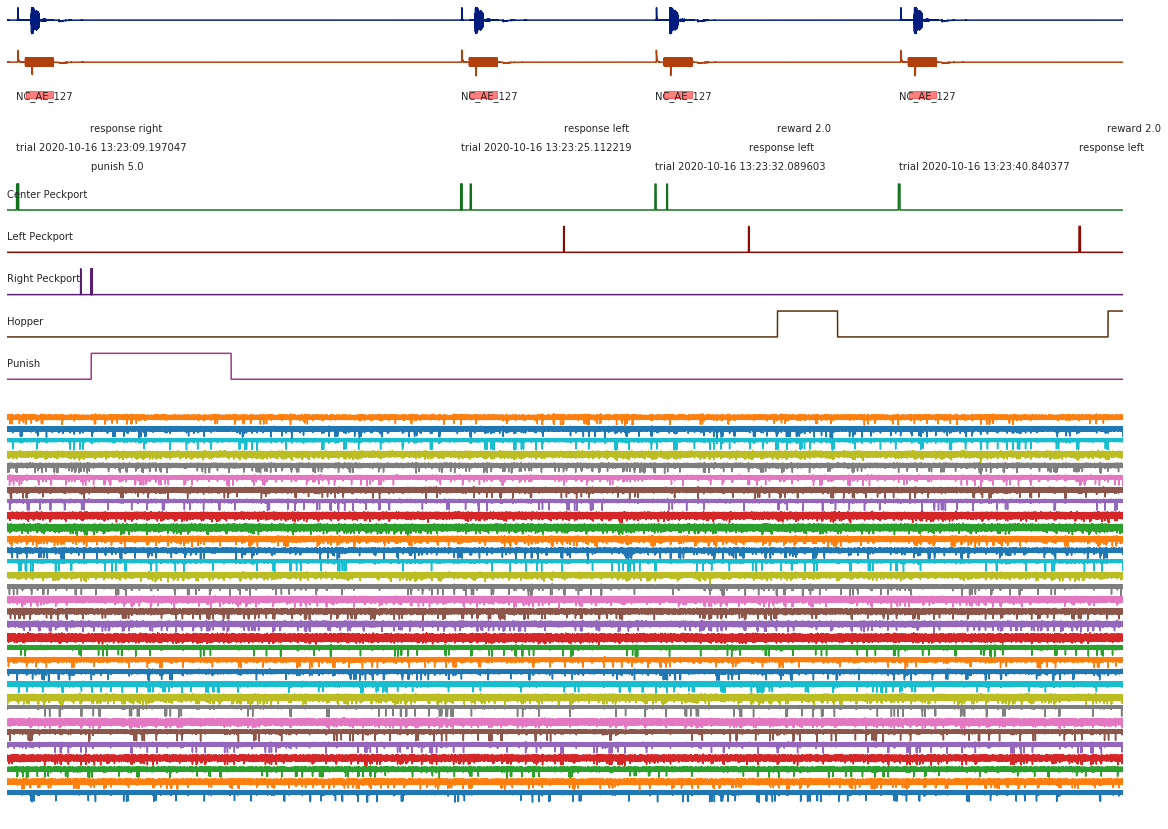

In [201]:
f, (a0, a1, a2, a3, a4, a5, a6, a7, a8, a9) = plt.subplots(
    nrows=10,
    ncols=1,
    figsize=(20, 15),
    gridspec_kw={"height_ratios": [1, 1, 0.25, 2, 1, 1, 1, 1, 1, 15]},
)
# plot audio
a0.plot(sample_ts, norm(audio_chan), color = dio_pal[0])
a0.axis("off")
a0.set_xlim([ts_start, ts_end])

# plot sine
a1.plot(sample_ts, norm(sine_chan), color = dio_pal[1])
a1.axis("off")
a1.set_xlim([ts_start, ts_end])

# plot audio start/end/ID
for idx, row in recording["audio_events"].iterrows():
    if (row.timestamp_end > ts_start) & (row.timestamp_begin > ts_start):
        a2.text(x=int(row.timestamp_stim), y=0, s=row.stim.split("/")[-1][:-4])
        a2.fill_between(
            x=[row.timestamp_begin, row.timestamp_end],
            y1=0,
            y2=1,
            color="red",
            alpha=0.5,
        )
a2.set_xlim([ts_start, ts_end])
a2.axis("off")

# plot zmq events
ln = 1
for idx, row in recording["network_events"].iterrows():
    if (row.timestamps > ts_start) & (row.timestamps < ts_end):
        if "stim" not in row.text:
            a3.text(
                row.timestamps, ln % 3, s=row.text
            )  # ha= 'left', va= 'top', , rotation=-45)
            ln += 1
a3.set_xlim([ts_start, ts_end])
a3.axis("off")
a3.set_ylim([0, 3])

# plot IR DIO events
def get_dio_state(recording, ts_start, ts_end, ID="Center Peck"):
    DIO_events = recording["FPGA_events"][recording["FPGA_events"].channel_ID == ID]
    channel_state = np.zeros(ts_end - ts_start)
    previous_state = 0
    for idx, row in DIO_events.iterrows():
        current_state = row.timestamps - ts_start
        if np.sign(row.channel_states) == 1:
            channel_state[previous_state:current_state] = 0
        else:
            channel_state[previous_state:current_state] = 1
        previous_state = current_state
    return channel_state


# center pecks
channel_state = get_dio_state(recording, ts_start, ts_end, ID="Center Peck")
a4.plot(np.arange(ts_start, ts_end), channel_state, color = dio_pal[2])
a4.set_xlim([ts_start, ts_end])
a4.text(ts_start, 0.5, "Center Peckport")
a4.axis("off")

# Left pecks
channel_state = get_dio_state(recording, ts_start, ts_end, ID="Left Peck")
a5.plot(np.arange(ts_start, ts_end), channel_state, color = dio_pal[3])
a5.set_xlim([ts_start, ts_end])
a5.text(ts_start, 0.5, "Left Peckport")
a5.axis("off")

# Right pecks
channel_state = get_dio_state(recording, ts_start, ts_end, ID="Right Peck")
a6.plot(np.arange(ts_start, ts_end), channel_state, color = dio_pal[4])
a6.set_xlim([ts_start, ts_end])
a6.text(ts_start, 0.5, "Right Peckport")
a6.axis("off")

# Hopper
channel_state = get_dio_state(recording, ts_start, ts_end, ID="Hopper")
a7.plot(sample_nums, channel_state, color = dio_pal[5])
a7.set_xlim([ts_start, ts_end])
a7.text(ts_start, 0.5, "Hopper")
a7.axis("off")

# house lights
channel_state = get_dio_state(recording, ts_start, ts_end, ID="GPIO22")
a8.plot(sample_nums, channel_state, color = dio_pal[6])
a8.set_xlim([ts_start, ts_end])
a8.text(ts_start, 0.5, "Punish")
a8.axis("off")

# neural data
for ti, trace in enumerate(neural_data_traces):
    a9.plot(sample_ts, norm(trace) + ti)
a9.set_xlim([ts_start, ts_end])
a9.axis('off')